In [2]:
import numpy as np
import scipy.cluster.vq
# import theano
# import theano.tensor as T
# import theano.tensor.nnet as nnet

import copy
import time
import pydot
import graphviz
import cv2 
import math
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal
from math import sqrt
from skimage import transform
import skimage 


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def prepImg(fileName, scale):
    img = cv2.imread(fileName, 0)
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(img,-1,kernel)
    img_rescaled = get_rescaled(dst, scale)    
    return img_rescaled

def get_rescaled(img, percent):
    width, height = img.shape
    resized = skimage.transform.resize(img, output_shape=[int(width * percent), 
                int(height * percent)], order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    return resized

In [5]:
combine = cv2.imread("./training/preprocess/img0_combined.jpg", 0)
combine1 = combine / 255
# plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
# plt.imshow(combine1)    


In [6]:
ksize = 7
kernel = cv2.getGaussianKernel(ksize, 0.3*((ksize-1)*0.5 - 1) + 0.8)
gaussk = signal.convolve2d(kernel, np.transpose(kernel))

# cutaway borders
border = 10
blurred = signal.convolve2d(combine1, gaussk, 'same')
cut = blurred[border:-border, border:-border]
# plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
# plt.imshow(cut)    


## functions

In [7]:
def findLines(maxAngl, minAngl, img):
    maxAngl = np.pi/2 + np.pi/6
    minAngl = np.pi/2 - np.pi/6
    lines = cv2.HoughLines(img, rho = 0.9, theta = np.pi/360, threshold = 100)
    empty = np.ones((600, 450))
    output = np.empty([1, 2])
    for item in lines:
        for rho, theta in item:
            if theta < maxAngl and theta > minAngl:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))
                cv2.line(empty,(x1,y1),(x2,y2),(1,1,1),1)
                output = np.append(output, np.array([rho, theta]).reshape(1,2), axis=0)

    output = np.reshape(output, (output.shape[0], 1, 2))
    #     return lines
    # assert output[:][0] is rho
    #        output[:][1] is theta
    return output[1:]

def makeMeans(k, crossings, lines):
    
    L = lines.shape[0]
    minx = np.inf
    maxx = -np.inf
    miny = np.inf
    maxy = -np.inf
    idx = 0

    for i in range(L):
        for j in range(i + 1, L):
            xcross = crossings[idx, 0]
            ycross = crossings[idx, 1]
            if minx > xcross:
                minx = xcross
            if maxx < xcross:
                maxx = xcross
            if miny > ycross:
                miny = ycross
            if maxy < ycross:
                maxy = ycross
            idx += 1
    
    means = np.ndarray([2, k])
    for i in range(k):
        x = np.random.uniform(minx, maxx, size=1)[0]
        y = np.random.uniform(miny, maxy, size=1)[0]    
        means[0][i] = x
        means[1][i] = y
    return means

def makeMeansAroundMean(k, distance, crossings):
    xMean = 0
    yMean = 0
    for idx in range(crossings.shape[0]):
        xMean += crossings[idx][0]
        yMean += crossings[idx][1]
    xMean = xMean/(idx + 1)
    yMean = yMean/(idx + 1)
    
    means = np.ndarray([2, k])
    for idx in range(k):
        angle = np.random.uniform(-np.pi, np.pi, size=1)[0]
        means[0, idx] = xMean + distance * idx * np.cos(angle)
        means[1, idx] = yMean + distance * idx * np.sin(angle)
        
    return means

def calcMandB(lines):
    # calculate m and b values for lines
    # y = mx + b 
    # x = p cos(O)
    # m = - tan(O)
    # b = cos(O)(p + 1/p)
    
    L = lines.shape[0]
    mb = np.ndarray([L, 2])
    for idx in range(L):
        rho = lines[idx][0][0]
        theta = lines[idx][0][1]
        mb[idx, 0] = -(np.pi/2 - theta)
        mb[idx, 1] = rho*(np.sin(theta) + np.cos(theta)**2/np.sin(theta))
        
    # assert mb[:,0] is m -- tilt of line
    # assert mb[:,1] is b -- crossing of y-axis
    
    return mb

def makeCrossings(mb):
    count = 0
    L = mb.shape[0]
    for i in range(L):
        for j in range(i + 1, L):
            count += 1

    crossings = np.ndarray([count, 2])
    idx = 0
    for i in range(L):
        for j in range(i + 1, L):
            # test case
            mb1 = mb[i,:]
            mb2 = mb[j,:]
            # a is tilt of line1
            # c is crossing of y axis line1
            # b is tilt of line2
            # d is crossing of y axis line2            
            a = mb1[0]
            c = mb1[1]
            b = mb2[0]
            d = mb2[1]

            div = a - b if (a - b != 0) else 1
            xcross = (d - c)/div
            ycross = (a * d - b * c)/div            
            crossings[idx, 0] = xcross
            crossings[idx, 1] = ycross
            idx += 1
            
    # assert: crossings[:, 0] is x coordinate
    #         crossings[:, 1] is y coordinate
    
    return crossings

def newMakeMeans(k, crossings, dist=10):
    xMean = 0
    yMean = 0
    for idx in range(crossings.shape[0]):
        xMean += crossings[idx][0]
        yMean += crossings[idx][1]
    xMean = xMean/(idx + 1)
    yMean = yMean/(idx + 1)
    means = np.ndarray([k, 2])
    for idx in range(k):
        angle = np.random.uniform(-np.pi, np.pi, size=1)[0]
        means[idx, 0] = xMean + dist * idx * np.cos(angle)
        means[idx, 1] = yMean + dist * idx * np.sin(angle)
    return means
    
def newClustering(k, cross, loops):
    L = cross.shape[0]

    cross_tweaked = np.tile(cross, (1, k))
    cross_tweaked = np.reshape(cross_tweaked, (L, k, 2))

    means = newMakeMeans(k, crossings)
    
    for p in range(loops):
    
        means_tweaked = np.tile(means, (L, 1))
        means_tweaked = np.reshape(means_tweaked, (L, k, 2))
        diff = np.linalg.norm(cross_tweaked - means_tweaked, axis=2)   
        positions = np.argmin(diff, axis=1).reshape(L, 1)
        
        bins = []
        for i in range(k):
            bins.append([])
        for idx in range(L):
            bins[positions[idx]].append(cross[idx])
        means = np.ndarray([k, 2])    
        for i in range(k):
            if len(bins[i]) == 0:
                means[i, :] = np.asarray([0, 0])
            else:                
                means[i, :] = np.sum(np.asarray(bins[i]), axis=0)/len(bins[i])
    return means, bins

def getH(img, vanishing_point):

    x, y = vanishing_point
    vp_vect = np.array([x, y, 1], dtype=np.float32)
    img_height, img_width = img.shape[:2]

    T1 = np.identity(3)
    T1[0, 2] = -img_width/2.0
    T1[1, 2] = -img_height/2.0
    
    vp_shift = T1.dot(vp_vect)
    vp_shift /= vp_shift[2]
    theta = np.arctan(vp_shift[1]/vp_shift[0])    

    R1 = np.array([[np.cos(theta), np.sin(theta), 0],
                  [-np.sin(theta), np.cos(theta), 0],
                  [0             , 0            , 1]])

    vp_vect_rot = R1.dot(T1).dot(vp_vect)
    vp_vect_rot /= vp_vect_rot[2]

    K1 = np.identity(3)
    K1[2, 0] = -1/vp_vect_rot[0]

    H = np.linalg.inv(T1).dot(K1).dot(R1).dot(T1)

#     print('vp_shift: {}'.format(vp_shift[:2]))
#     print('theta: {}'.format(theta))    
#     print('R1:\n{}'.format(R1))
#     print('R1T1:\n{}'.format(R1.dot(T1)))    
#     print('T1:\n{}'.format(T1))
#     print('T1 inv :\n{}'.format(np.linalg.inv(T1)))
#     print('multiply:\n{}'.format(T1.dot(np.linalg.inv(T1))))
    
    return H

# visualize vanishing points
def showVanPoint(k, img, van_points, cross, lines=[], add_lines=False):

    # extend image
    img_height, img_width = img.shape
    width_ext = 2200
    height_ext = 1000
#     width_ext = np.amax(van_points[:, 0])
#     height_ext = -np.amin(van_points[:, 1])
    
    print width_ext
    print height_ext
 
    ext_img = np.append(img, np.zeros([img_height, width_ext]), axis=1)
    ext_img = np.append(np.zeros([height_ext, img_width + width_ext]), ext_img, axis=0)
    rad = 6
    
    for idx in range(L):
        new_x = cross[idx][0]
        new_y = cross[idx][1] + height_ext
        ext_img[new_y-rad:new_y+rad, new_x-rad:new_x+rad] = 0.75
    
    for i in range(k):
        new_x = van_points[i, 0]
        new_y = van_points[i, 1] + height_ext
        ext_img[new_y-rad:new_y+rad, new_x-rad:new_x+rad] = 0.5
    
    if add_lines:
        for item in lines:
            for rho, theta in item:
                R = height_ext * np.sin(theta) + rho
                if theta < maxAngl and theta > minAngl:
                    a = np.cos(theta)
                    b = np.sin(theta)
                    x0 = a*R
                    y0 = b*R
                    x1 = int(x0 + 10000*(-b))
                    y1 = int(y0 + 10000*(a))
                    x2 = int(x0 - 10000*(-b))
                    y2 = int(y0 - 10000*(a))
                    cv2.line(ext_img,(x1,y1),(x2,y2),(0.25,0.25,0.25),1)

    return ext_img

## create data

In [33]:
k = 10
# L = lines.shape[0]
maxAngl = np.pi/2 + np.pi/6
minAngl = np.pi/2 -np.pi/6

# ------------------------------------------
lines = findLines(maxAngl, minAngl, combine1)
# assert output[:][0] is rho
#        output[:][1] is theta
# print lines[0]
# check, assertion True!
# ------------------------------------------
mb = calcMandB(lines)
# assert mb[:,0] is m -- tilt of line
#        mb[:,1] is b -- crossing of y-axis
# print mb[0]
# check, assertion True!
# ------------------------------------------
crossings = makeCrossings(mb)
# assert: crossings[:, 0] is x coordinate
#         crossings[:, 1] is y coordinate
# print crossings.shape
# this assertion is hard to validate!
# ------------------------------------------
# van_points, bins = clusterMeans(k, 10, crossings)
# van_points, bins = newClustering(k, crossings, 10)
van_points, bins = scipy.cluster.vq.kmeans2(crossings, k, 50, minit='points')


In [34]:
img = copy.deepcopy(combine1)

##  get pixels that are not 1

In [51]:
height, width = img.shape
count = 0 
pixels = []
for x in range(width):
    for y in range(height):
        if img[y, x] != 0:
            pixels.append(np.asarray([float(y), float(x)]))
pixels = np.asarray(pixels)

## remove vanishing points that are inside the image

In [52]:
newvps = []
height, width = img.shape
for idx in range(van_points.shape[0]):
    vp = van_points[idx]
    if not (vp[0] > 0 and vp[0] < width and vp[1] > 0 and vp[1] < height):
        newvps.append(vp)
    else:
        print "vp with idx: " + str(idx) + " lying in image plane"
    
van_points = np.asarray(newvps)

## projection profiles as described by paper

In [58]:
# H = (H_r, H_theta)
# p = vector from middle of image to pixel 

def projectp(img, pixel):
    # (x, y)     
    height, width = img.shape
    middle = np.asarray([width/2.0, height/2.0])
    p = pixel - middle
    return p

def projectH(vp, pixel):
    vector = pixel - vp
    angle = np.arctan2(vector[0], vector[1])
    # angle defined for [-pi, pi]
    return np.asarray([np.cos(angle), np.sin(angle)])

def projecti(img, N, vp, pixel):
    H = projectH(vp, pixel)
    p = projectp(combine1, pixel)
    height, width = img.shape
    angle = np.dot(H, p)
    
    s = np.sqrt(width**2 + height**2)
    i = 0.5 * N + N * np.dot(H, p) / s
    return i

def makeprofiles(img, N, van_points, pixels):
    profiles = []
    for idx in range(0, van_points.shape[0]):
        vp = van_points[idx]
        profile = []
        for p in range(pixels.shape[0]):
            i = projecti(img, N, vp, pixels[p])
            profile.append(i)
        profiles.append(profile)
    return np.asarray(profiles)

def makehistograms(profiles, N):
    binmax = np.max(profiles[0])
    binmin = np.min(profiles[0])
    binwidth = (binmax - binmin) / N
    bins = []
    histograms = []
    
    for idx in range(0, N + 1):
        bins.append((idx)*binwidth + binmin)

    for idx in range(profiles.shape[0]):
        hist, hist_edges = np.histogram(profiles[idx], bins) 
        histograms.append((hist, hist_edges))
        
    return histograms, binwidth, bins

In [59]:
N = 10
profiles = makeprofiles(img, N, van_points, pixels)
numberbins = 10
histograms, binwidth, bins = makehistograms(profiles, numberbins)

idx: 0 : [-12056.49074437   5960.66786139]
idx: 1 : [ 17216.26791705  -7359.97913592]
idx: 2 : [ 2559.43297542  -663.89914757]
idx: 3 : [ 10416.92580486  -4283.84616697]
idx: 4 : [-3010.23939448  1843.09704278]
idx: 5 : [ 4209.36287543 -1426.08342329]
idx: 6 : [ 6531.50834228 -2497.37772342]
idx: 7 : [-374.22304542  657.23720587]
idx: 8 : [-6482.64755075  3438.937892  ]


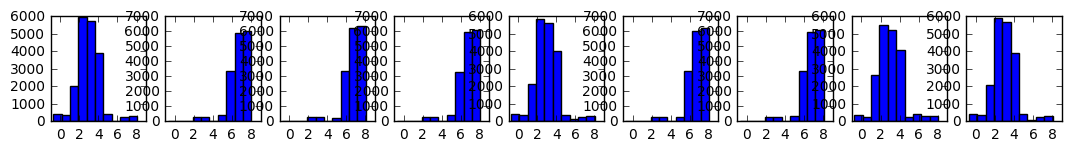

In [64]:

plt.figure(figsize=(16, 16))
for idx in range(len(histograms)):
    print('idx: {} : {}'.format(idx, van_points[idx]))
    plt.subplot(10, 11, idx+1)    
    plt.bar(histograms[idx][1][:-1], histograms[idx][0], binwidth) 

## choose best projection profile

[34125039 15377038 17916448 15615454 33023391 16644377 16044357 30002397
 33511134]
1


4434117.44
2
6236916.21
7
[-374.22304542  657.23720587]


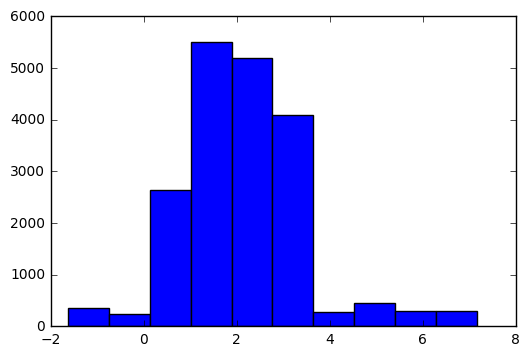

In [61]:
# Derivative-squared-sum : nabla S(B) = sum (B_{i+1} - B_i)^2 
nablas = []
for idx in range(len(histograms)):
    NS = 0
    for bidx in range(len(histograms[idx][0])-1):
        NS += (histograms[idx][0][bidx+1] - histograms[idx][0][bidx])**2 
    nablas.append(NS)
nablas = np.asarray(nablas)

print nablas
minpos = np.argmin(nablas)
print minpos
# Variance:
maxv = -np.inf
minv = np.inf
for idx in range(len(histograms)):
    variance = np.nanvar(histograms[idx][0])
    if maxv < variance:
        maxv = variance
        maxpos = idx
    if minv > variance:
        minv = variance
        minpos = idx

print "\n"
print minv
print maxpos
print maxv
print minpos
# print histograms[minpos, 0][]
plt.bar(histograms[minpos][1][:-1], histograms[minpos][0], bins[0]-bins[1])
plt.show
print van_points[minpos]

<function matplotlib.pyplot.show>

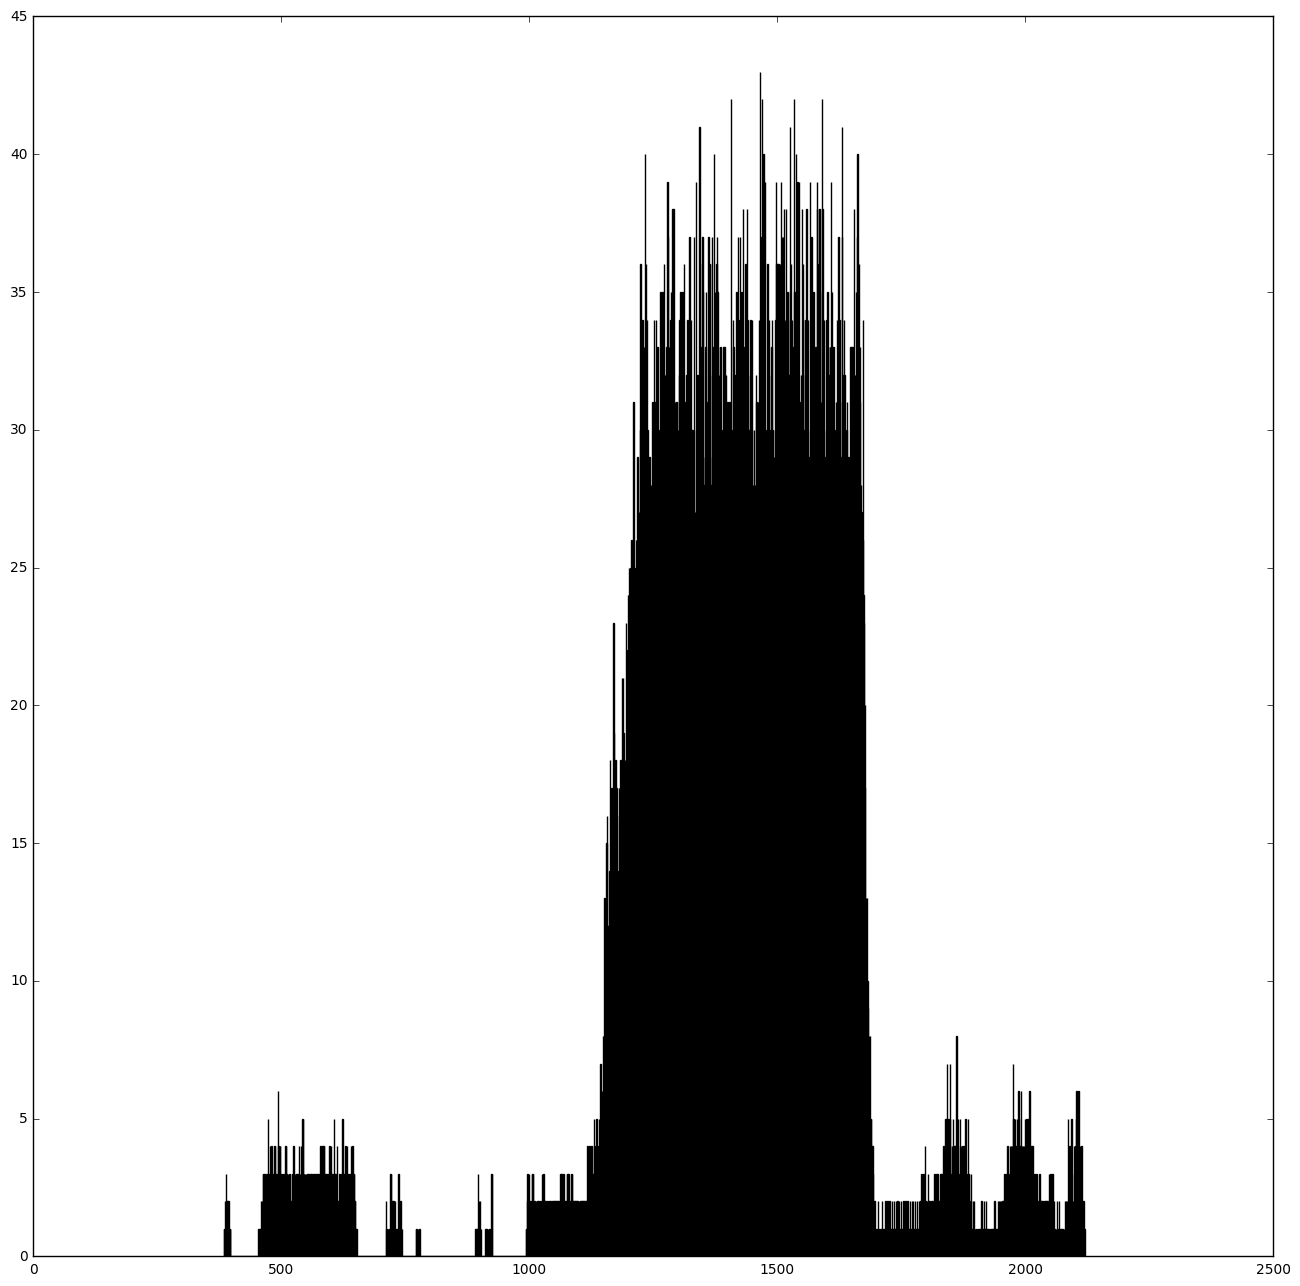

In [392]:
vp = np.asarray([2900,-950])
N = 2000
profile = []
for p in range(pixels.shape[0]):
    i = projecti(img, N, vp, pixels[p])
    profile.append(i)
    
profiles = []
profiles.append(profile)
profiles = np.asarray(profiles)
histograms, binwidth = makehistograms(profiles, N)

plt.figure(figsize=(16, 16))
plt.bar(histograms[0][1][:-1], histograms[0][0], binwidth) 
plt.show

## transform image

168


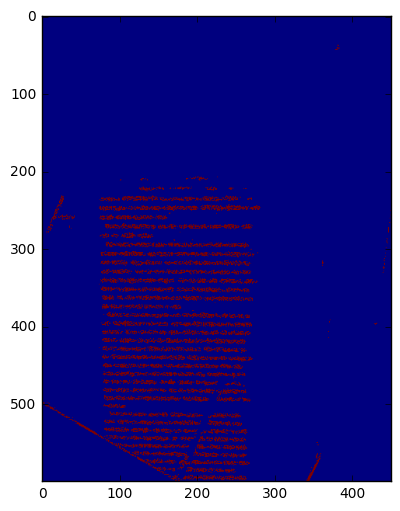

In [384]:
idx = 168
print idx

vp = np.asarray([2900,-950])
# van_points[idx])
h = getH(combine1, vp)
hinv = np.linalg.inv(h)
H, W = combine1.shape
result_processed = cv2.warpPerspective(combine1, h, (W, H))
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(result_processed) 

1   [ 2464.15438823  -620.74287329]
8   [ 1460.85984697  -163.80598213]
2200
1000


/Users/olaroos/virtualenvs/cv/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olaroos/virtualenvs/cv/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


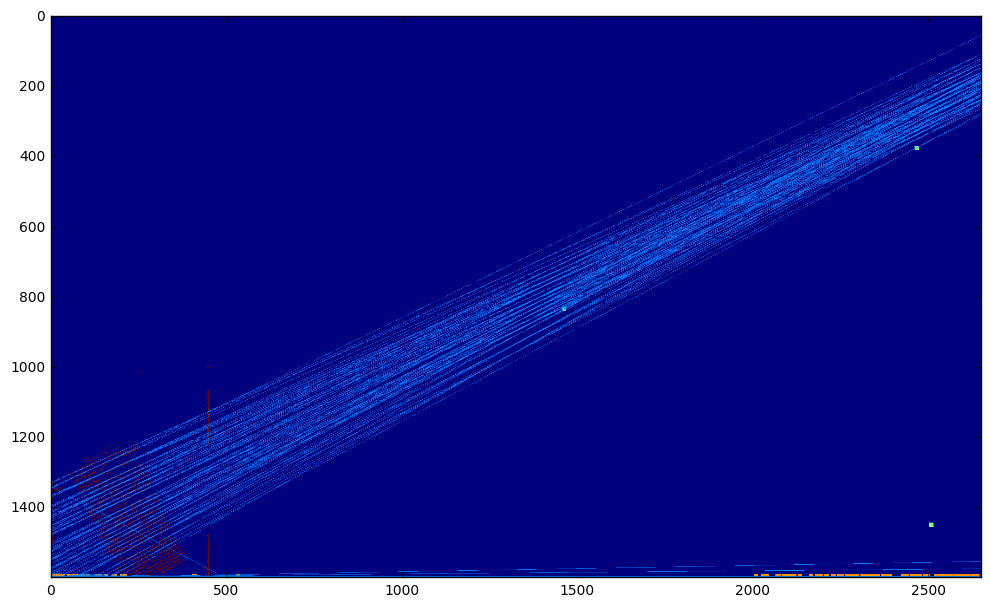

In [332]:

for i in range(van_points.shape[0]):
    if van_points[i][0] > 1000 and van_points[i][0] < 3000:
        print str(i) + "   " + str(van_points[i])

ext_img = showVanPoint(k, combine1, van_points, crossings, lines, True)
plt.figure(figsize = (12,12))
plt.imshow(ext_img)


In [288]:
import scipy.cluster.vq

In [97]:
k = 20
L = lines.shape[0]
maxAngl = np.pi/2 + np.pi/6
minAngl = np.pi/2 - np.pi/6

# ------------------------------------------
lines = findLines(maxAngl, minAngl, combine1)
# assert output[:][0] is rho
#        output[:][1] is theta
# print lines[0]
# check, assertion True!
# ------------------------------------------
mb = calcMandB(lines)
# assert mb[:,0] is m -- tilt of line
#        mb[:,1] is b -- crossing of y-axis
# print mb[0]
# check, assertion True!
# ------------------------------------------
crossings = makeCrossings(mb)
# assert: crossings[:, 0] is x coordinate
#         crossings[:, 1] is y coordinate
# print crossings.shape
# this assertion is hard to validate!
# ------------------------------------------
# van_points, bins = clusterMeans(k, 10, crossings)
# van_points, bins = newClustering(k, crossings, 10)
van_points, bins = scipy.cluster.vq.kmeans2(crossings, k, 10, minit='points')
print(van_points.shape)
# ----------------------

(20, 2)


2200
1000


/Users/olaroos/virtualenvs/cv/lib/python2.7/site-packages/ipykernel/__main__.py:229: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olaroos/virtualenvs/cv/lib/python2.7/site-packages/ipykernel/__main__.py:234: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


2200
1000
2200
1000
2200
1000
2200
1000
2200
1000
2200
1000
2200
1000


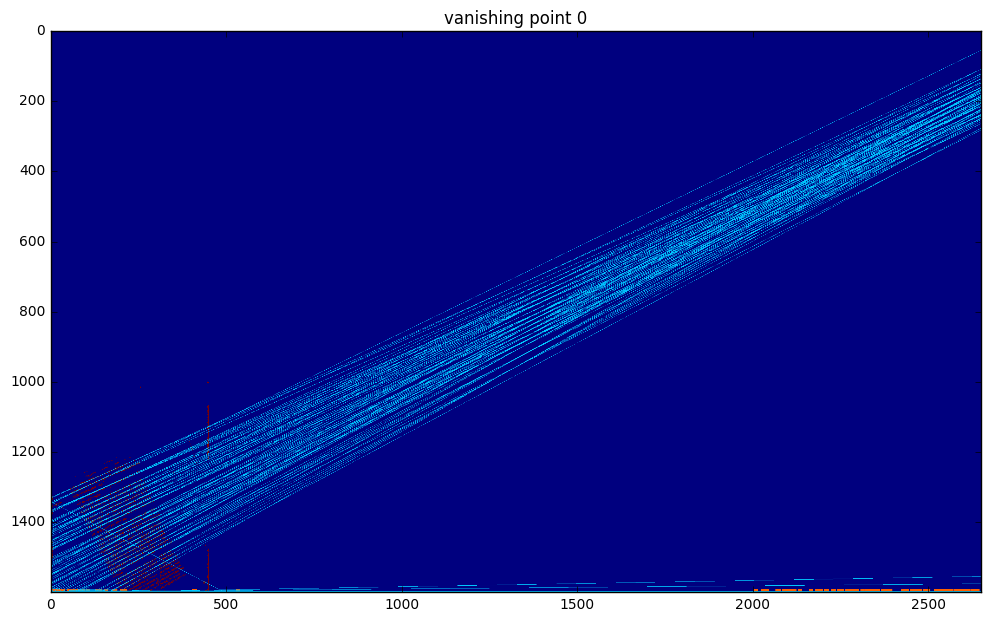

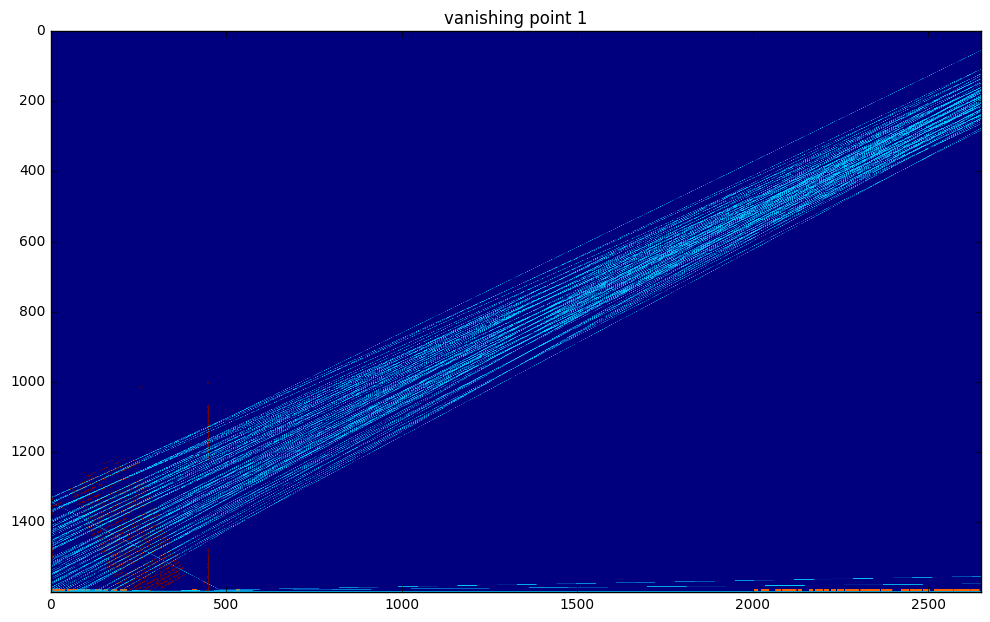

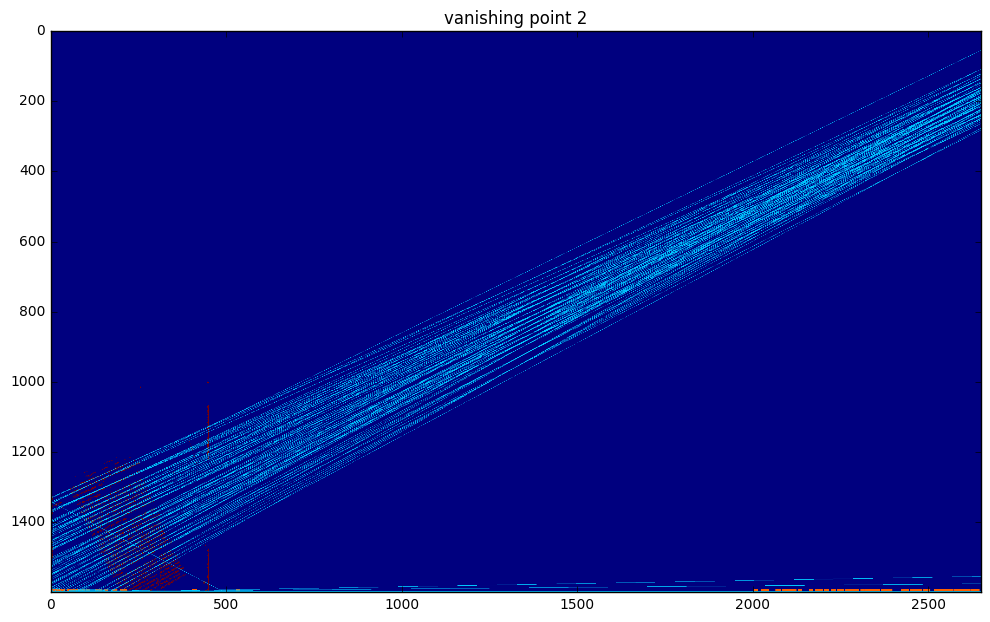

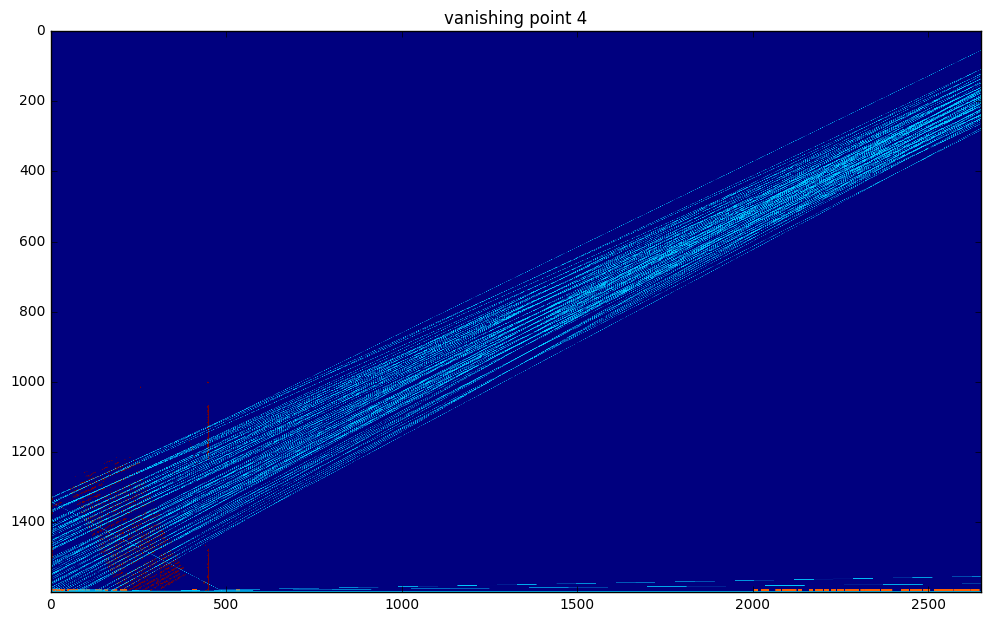

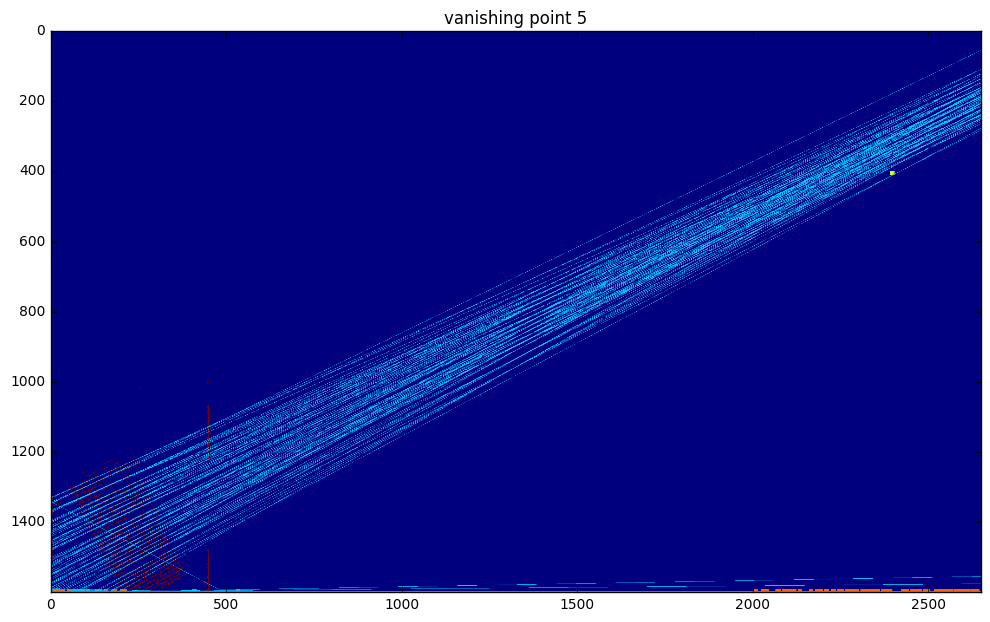

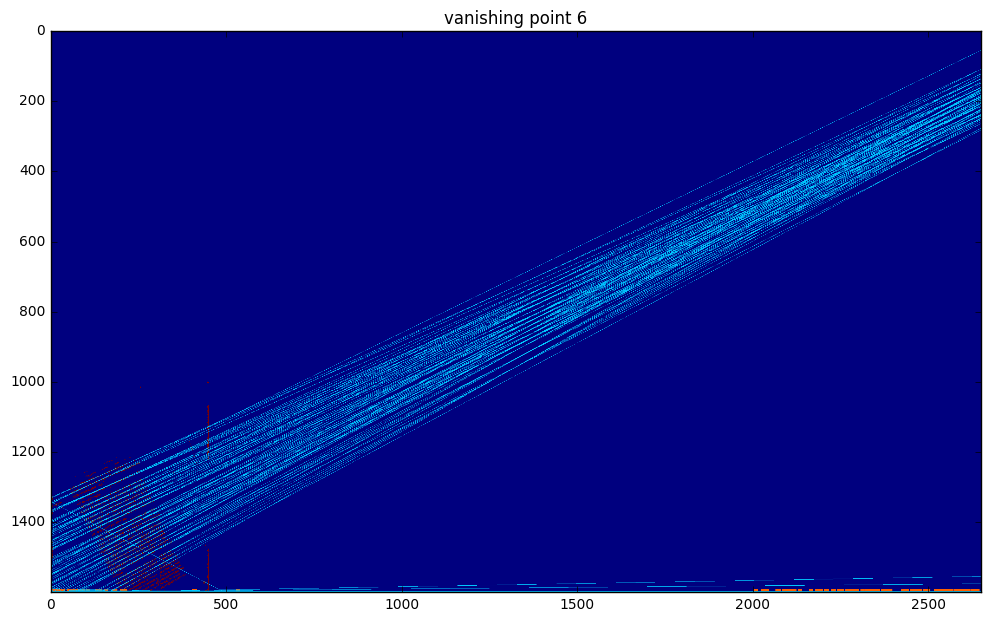

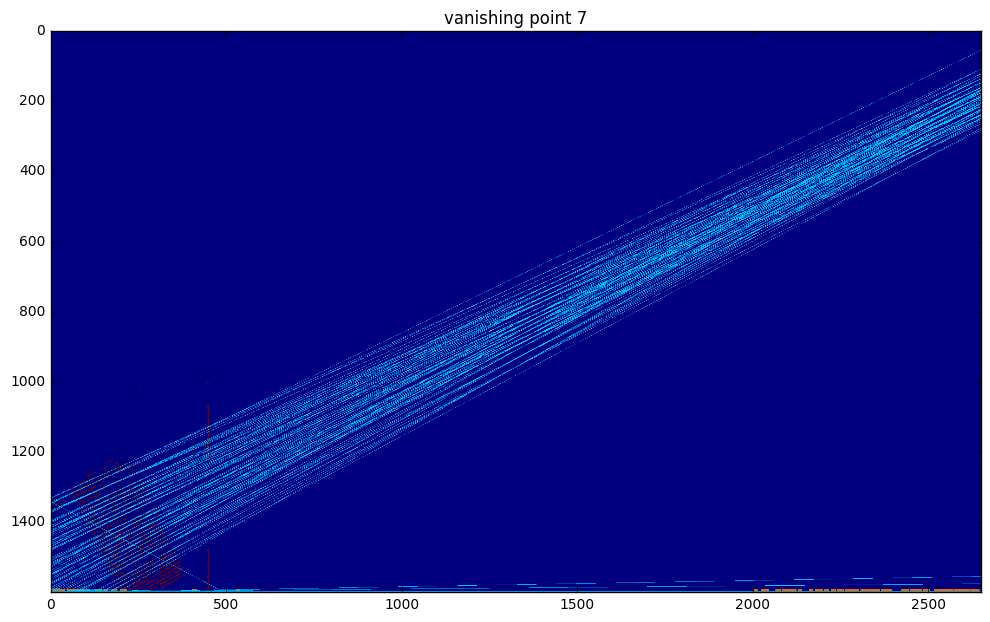

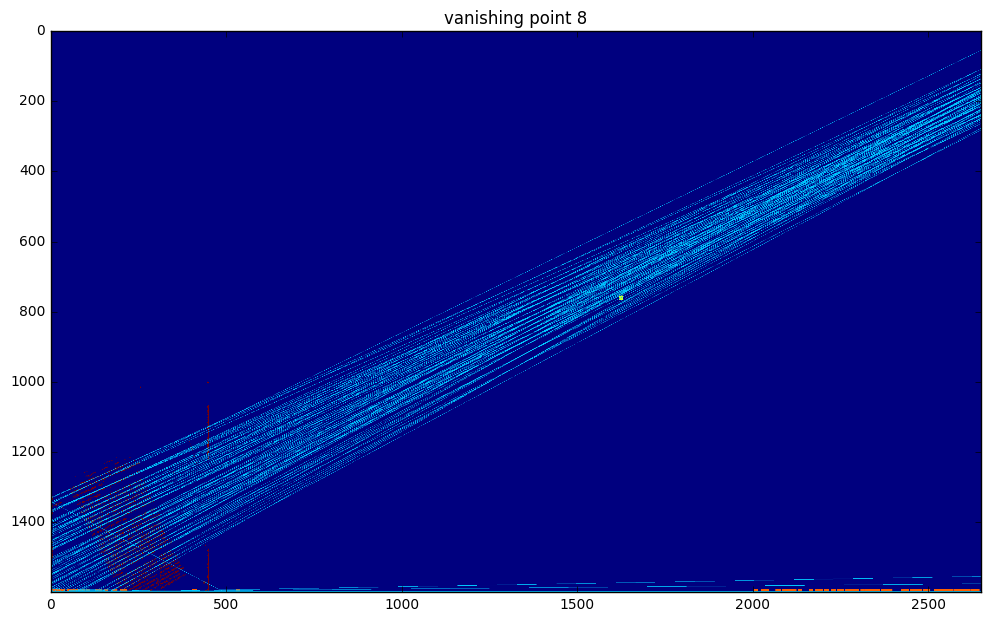

In [98]:
for i in range(10):
    if van_points[i, 0] < 0 or van_points[i, 1] >= 0:
        continue
    ext_img = showVanPoint(1, combine1, van_points[i:i+1], crossings, lines, True)
    plt.figure(figsize = (12,12))
    plt.imshow(np.log(1+ext_img))
    plt.title('vanishing point {}'.format(i))
#     print(van_points)

## transform img ## 

(168, 168, 3)


/Users/olaroos/virtualenvs/cv/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in double_scalars


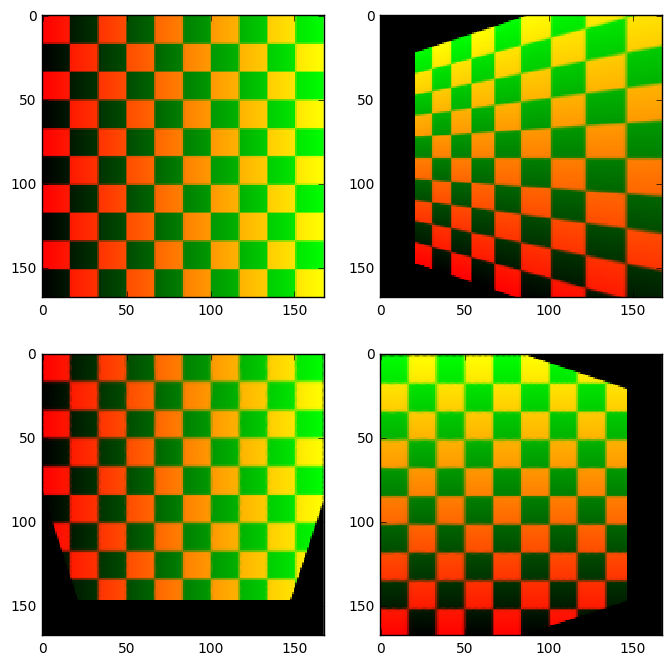

In [330]:
# tst = cv2.imread('./img/checkerboard.png')
import scipy.misc
tsts = scipy.misc.imread('./img/checkerboard.png')
H, W, C = tst.shape
tst = np.zeros((H, W, 3), dtype=tsts.dtype)
tst[..., 0] = tsts[..., 3]
tst[..., 1] = np.linspace(0, 255, W)
print(tst.shape)
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(tst, interpolation='none')
img_width, img_height, _ = tst.shape

h = getH(tst, [img_width/2.0, img_height*2.0])
# h_inv = np.linalg.inv(h)

aff = cv2.warpPerspective(tst, h, (img_height, img_width))
plt.subplot(2, 2, 2)
plt.imshow(aff, interpolation='none')

orig = cv2.warpPerspective(aff, np.linalg.inv(h), (img_height, img_width))
plt.subplot(2, 2, 3)
plt.imshow(orig, interpolation='none')

# orig2 = cv2.warpPerspective(aff, h, (img_height, img_width), flags=cv2.WARP_INVERSE_MAP)
# plt.subplot(2, 2, 4)
# plt.imshow(orig2, interpolation='none')

new_h = getH(aff, [-img_width, img_height/2.0])
# np.linalg.inv(
reverse = cv2.warpPerspective(aff, new_h, (img_height, img_width))
plt.subplot(2, 2, 4)
plt.imshow(reverse, interpolation='none')



<type 'numpy.ndarray'>
2200
1000
vp_shift: [ 1875.  -800.]
theta: -0.403281481719
R1:
[[ 0.91977817 -0.39243869  0.        ]
 [ 0.39243869  0.91977817  0.        ]
 [ 0.          0.          1.        ]]
R1T1:
[[   0.91977817   -0.39243869  -89.2184823 ]
 [   0.39243869    0.91977817 -364.23215456]
 [   0.            0.            1.        ]]
T1:
[[   1.    0. -225.]
 [   0.    1. -300.]
 [   0.    0.    1.]]
T1 inv :
[[   1.    0.  225.]
 [   0.    1.  300.]
 [   0.    0.    1.]]
multiply:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[  2.03853501e+03  -1.13686838e-13  -2.22044605e-16]
[[  8.18259143e-01  -3.49123901e-01   1.45628863e+02]
 [  2.57079984e-01   9.77531214e-01  -5.11023606e+01]
 [ -4.51195669e-04   1.92510152e-04   1.04376598e+00]]


/Users/olaroos/virtualenvs/cv/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


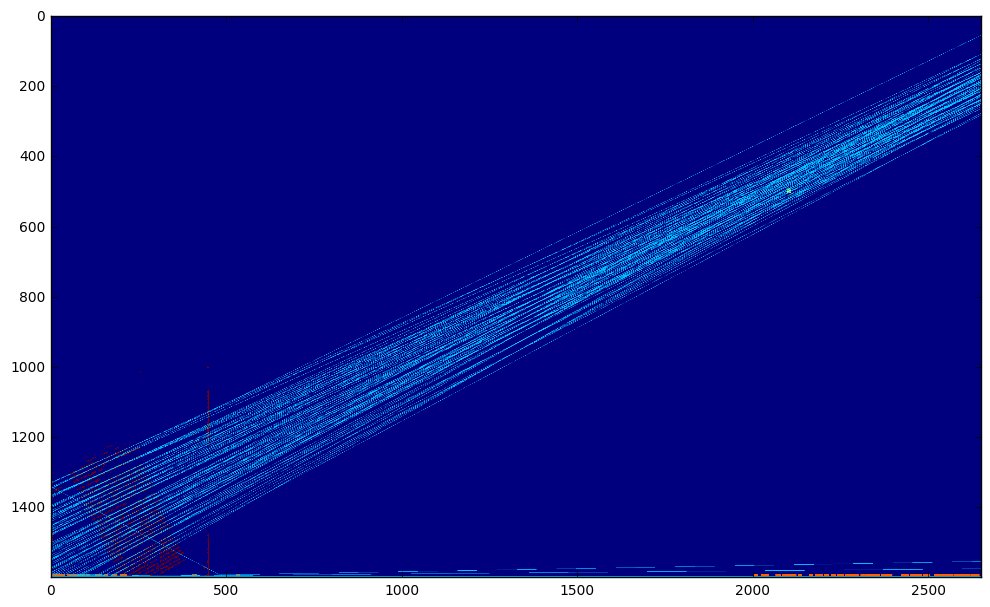

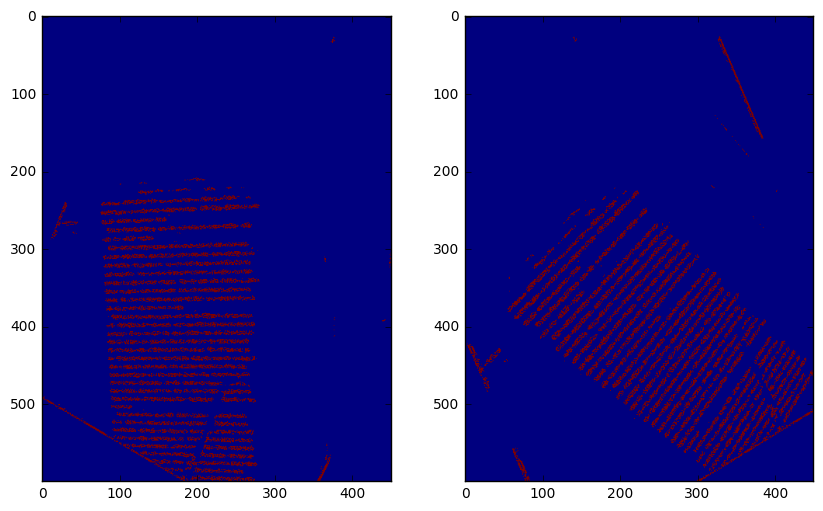

In [306]:
v_point = [[2100, -500]]
print van_points.__class__

H, W = combine1.shape[:2]

v_point = np.asarray(v_point)
ext_img = showVanPoint(1, combine1, v_point, crossings, lines, True)
plt.figure(figsize = (12,12))
plt.imshow(np.log(1+ext_img))


h = getH(combine1, v_point[0])
hinv = np.linalg.inv(h)
result_processed = cv2.warpPerspective(combine1, h, (W, H))
print(h)

# result = cv2.warpPerspective(original, h, (W, H))
result_affine = cv2.warpPerspective(combine1, hinv, (W, H))
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(result_processed) 
# plt.subplot(1, 3, 2)
# plt.imshow(result_processed)
plt.subplot(1, 2, 2)
plt.imshow(result_affine)
# plt.title(str(van_points[i, :]/) + "\n" + "i is: " + str(i))

(600, 450, 3)
(600, 450)
0
vanishing point coords after rotation: [ -4.09707294e+03  -2.17629514e+02   1.00000000e+00]
R1T1:
[[  9.52898575e-01   3.03289147e-01  -3.05388923e+02]
 [ -3.03289147e-01   9.52898575e-01  -2.17629514e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ 0.95289857  0.30328915  0.        ]
 [-0.30328915  0.95289857  0.        ]
 [ 0.          0.          1.        ]]
1
vanishing point coords after rotation: [ -1.11903255e+04  -1.92438721e+02   1.00000000e+00]
R1T1:
[[   0.92550816    0.37872767 -321.85763699]
 [  -0.37872767    0.92550816 -192.43872145]
 [   0.            0.            1.        ]]
[[ 0.92550816  0.37872767  0.        ]
 [-0.37872767  0.92550816  0.        ]
 [ 0.          0.          1.        ]]
2
vanishing point coords after rotation: [  7.79443582e+03  -1.61709112e+02   1.00000000e+00]
R1T1:
[[   0.88632629    0.46306123 -338.34178423]
 [  -0.46306123    0.88632629 -161.70911244]
 [   0.            0.            1.        ]]
[[ 0

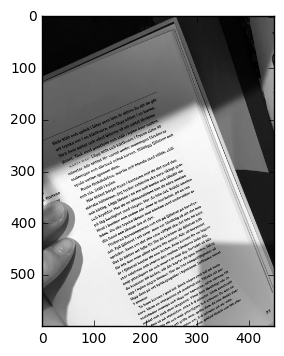

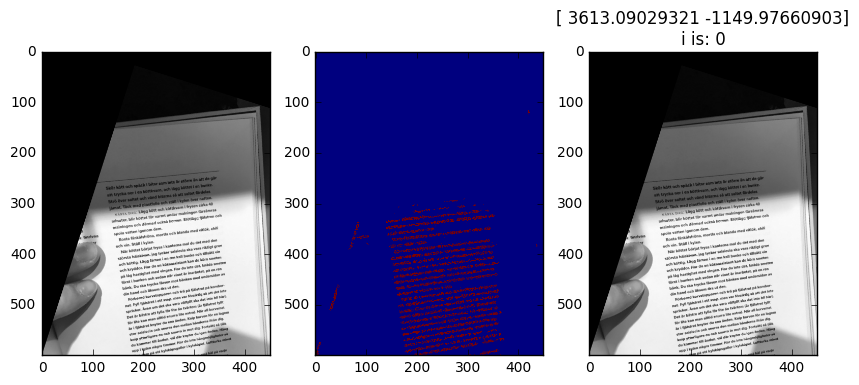

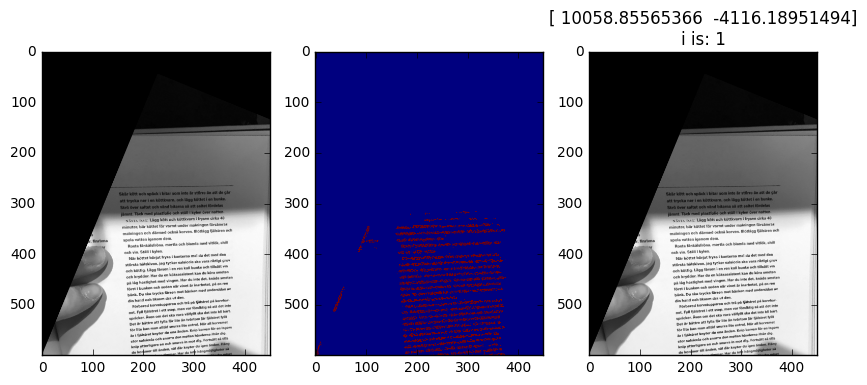

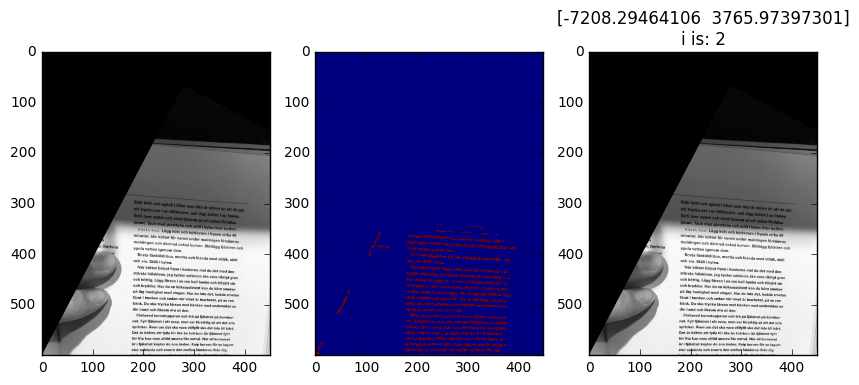

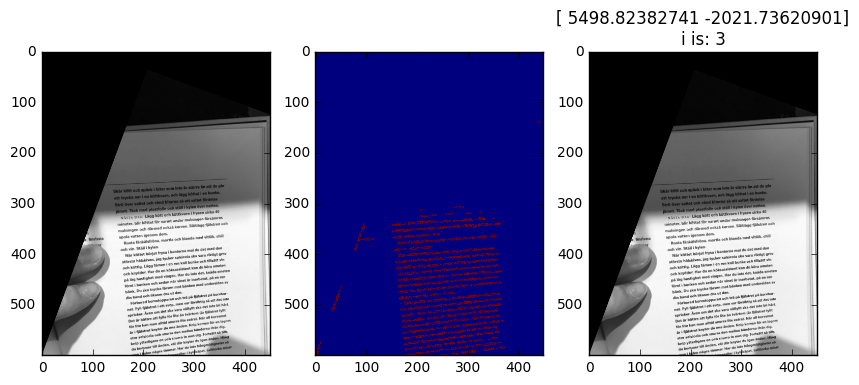

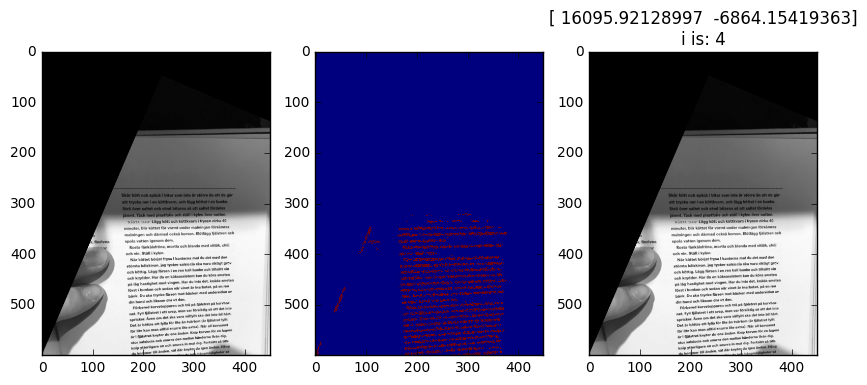

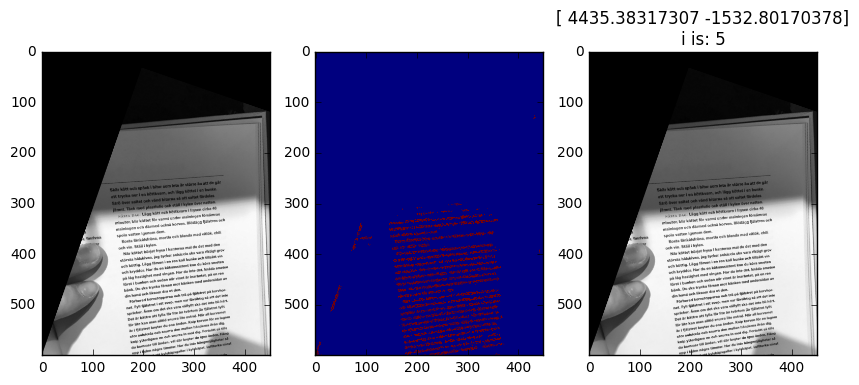

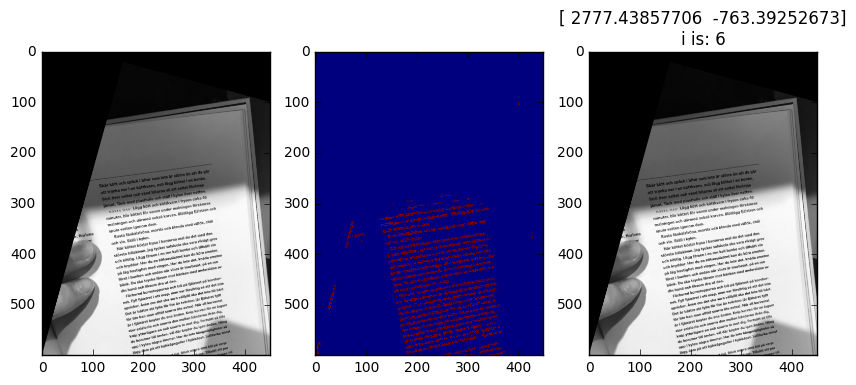

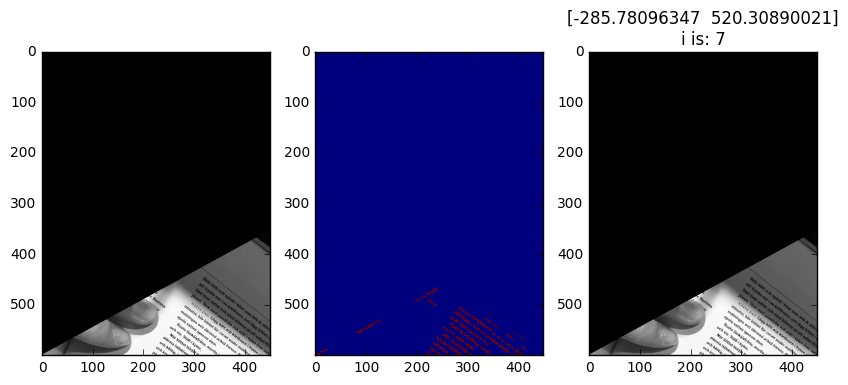

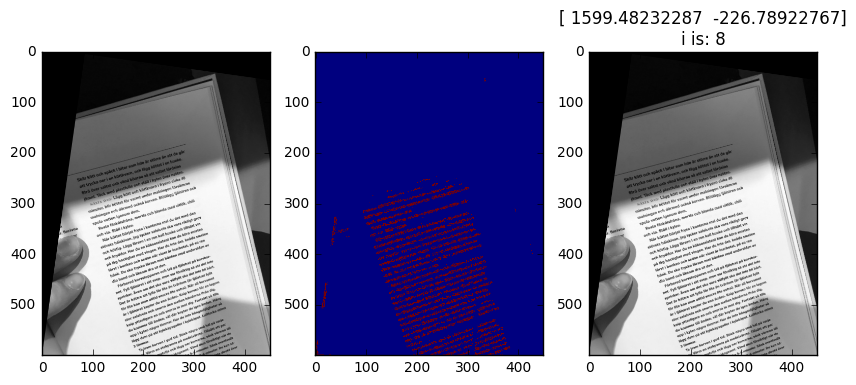

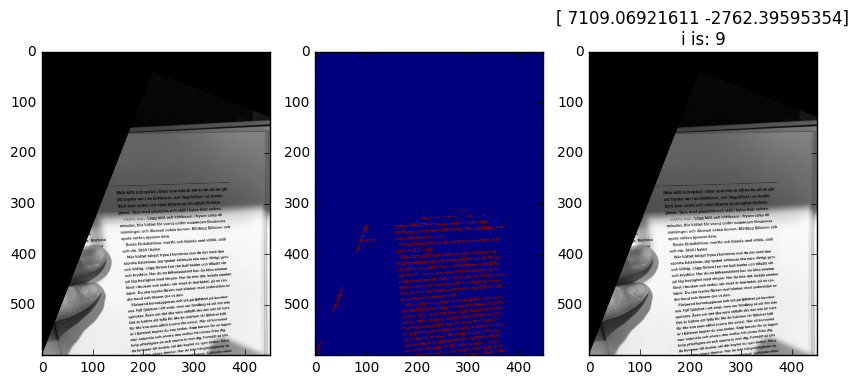

In [94]:

original = cv2.imread('./training/preprocess/img0_input.jpg')

print original.shape
print combine1.shape
import cv2 

plt.figure()
plt.imshow(original)

img_height, img_width, C = original.shape
img_height_processed, img_width_processed = combine1.shape
van_points.shape[0]
van_points_flip = van_points.copy()
van_points_flip[:, 0] *= -1
for i in range(van_points.shape[0]):    
    print i
    h = getH(combine1[::-1], van_points_flip[i])
    result_processed = cv2.warpPerspective(combine1[::-1], h, (img_width_processed, img_height_processed))[::-1]
    print(h)
    result = cv2.warpPerspective(original[::-1], h, (img_width, img_height))[::-1]
    result_affine = cv2.warpAffine(original[::-1], h[:2], (img_width, img_height))[::-1]
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(result) 
    plt.subplot(1, 3, 2)
    plt.imshow(result_processed)
    plt.subplot(1, 3, 3)
    plt.imshow(result_affine)
    plt.title(str(van_points[i, :]) + "\n" + "i is: " + str(i))